# Min et al Life Facet Replication

In [1]:
%matplotlib inline

from collections import Counter
import inspect
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
import sklearn.metrics as sk_metrics
from sklearn.svm import SVC

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from model.model_util import *


In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

## Min et al data

- 40 participants, 817 contacts
- 16,940 calls, 63,893 SMS

![Resampled evaluation data](zimmerman_figs/resample_data.png)

## Our data

- 199 participants, 4,785 contacts
- 38,749 calls, 279,089 SMS

In [3]:
with open("../data/all_contacts_final.df", "rb") as comm_f:
    comm_df = pickle.load(comm_f)

In [4]:
replace_dict = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "family_live_separate": 2,
        "family_live_together": 2,
        "sig_other": 2
    }
}


# with open("../data/zimmerman_contacts.df", "rb") as z_file:
#     zimmerman_df = pickle.load(z_file)

zimmerman_contact_types = ['work', 'social', 'family']
rev_replace_dict = {
    'contact_type': {idx:v for idx, v in enumerate(zimmerman_contact_types)}
}
zimmerman_df = comm_df.loc[(comm_df['contact_type'] != 'other') & (comm_df['contact_type'] != 'task')]
zimmerman_df = zimmerman_df.replace(replace_dict)
zimmerman_df = zimmerman_df.replace(rev_replace_dict)

In [5]:
# with open("../data/zimmerman_contacts.df", "wb") as z_file:
#     pickle.dump(zimmerman_df, z_file, -1)

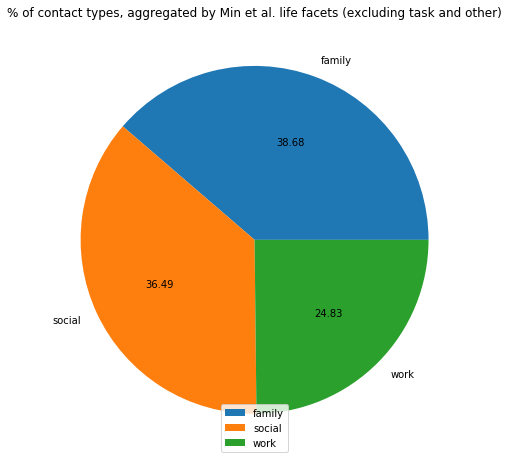

In [6]:
all_types = zimmerman_df.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types, aggregated by Min et al. life facets (excluding task and other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

In [7]:
display(all_types.loc[:, 'comm_direction'])

contact_type
family    1851
social    1746
work      1188
Name: comm_direction, dtype: int64

## Experiment parameters

- random downsampling to balance data
- 10 fold CV, average accuracy
- one vs one polynomial SVM

## Results

![](zimmerman_figs/life_facet_results.png)

In [8]:
# load models and data
features = ['baseline', 'all']

svc_models = []
svc_preds = []
svc_cv_preds = []
# baseline
for feat in features:
    with open("../model/final_results/zimmerman/zimmerman_contact_type_{}_svm.automl".format(feat), 'rb') as model_file:
            svc_models.append(pickle.load(model_file))
    with open("../model/final_results/zimmerman/zimmerman_contact_type_{}_svm.predict".format(feat), 'rb') as pred_file:
        svc_preds.append(pickle.load(pred_file))
    with open("../model/final_results/zimmerman/{}_svm.cv_predict".format(feat), 'rb') as cv_file:
        svc_cv_preds.append(pickle.load(cv_file))


automl_models = []
automl_preds = []
automl_cv_preds = []

# autoML
for feat in features:
    with open("../model/final_results/zimmerman/zimmerman_contact_type_{}_automl.automl".format(feat), 'rb') as model_file:
        automl_models.append(pickle.load(model_file))
    with open("../model/final_results/zimmerman/zimmerman_contact_type_{}_automl.predict".format(feat), 'rb') as pred_file:
        automl_preds.append(pickle.load(pred_file))
    with open("../model/final_results/zimmerman/{}_automl.cv_predict".format(feat), 'rb') as cv_file:
        automl_cv_preds.append(pickle.load(cv_file))


/home/tliu526/miniconda3/envs/auto-sklearn/lib/python3.7/site-packages/pyparsing.py:2725: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


In [9]:
contact_dict =  {
            "work": 0,
            "social": 1,
            "family": 2
        }


replace_dict = {'contact_type': contact_dict}

# load data
train = pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_baseline_train_features.df', 'rb'))
test =  pickle.load(open('../data/zimmerman_features/zimmerman_contact_type_baseline_test_features.df', 'rb'))

train_data = train.replace(replace_dict)
test_data = test.replace(replace_dict)

train_y = train_data['contact_type']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)
test_y = test_data['contact_type']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'], axis=1)

# create group folds
rand_seed = 2

sm = RandomUnderSampler(random_state=rand_seed)

train_X, train_y = sm.fit_resample(train_X, train_y)


pid_groups = build_cv_groups(pd.Series(train_X[:,0])) # pid col
train_X = train_X[:, 1:]

group_kfold = GroupKFold(n_splits=10)

fold_true_labels = []
for train_idx, test_idx in group_kfold.split(train_X, train_y, pid_groups):
    
    train_fold_X = train_X[train_idx]
    train_fold_y = train_y[train_idx]
    
    test_fold_X = train_X[test_idx]
    test_fold_y = train_y[test_idx]
    fold_true_labels.append(test_fold_y)

## 10-fold CV performance

In [10]:
def get_f1_acc(fold_true_labels, preds):
    acc = [sk_metrics.accuracy_score(true, pred) for true, pred in zip(fold_true_labels, preds)]
    f1 = [sk_metrics.f1_score(true, pred, average='weighted') for true, pred in zip(fold_true_labels, preds)]
    return acc, f1

In [11]:
svc_base_acc, svc_base_f1 = get_f1_acc(fold_true_labels, svc_cv_preds[0])
svc_all_acc, svc_all_f1 = get_f1_acc(fold_true_labels, svc_cv_preds[1])

automl_base_acc, automl_base_f1 = get_f1_acc(fold_true_labels, automl_cv_preds[0])
automl_all_acc, automl_all_f1 = get_f1_acc(fold_true_labels, automl_cv_preds[1])

In [12]:
svc_base_mean_acc = np.mean(svc_base_acc)
svc_base_std_acc = np.std(svc_base_acc)
svc_all_mean_acc = np.mean(svc_all_acc)
svc_all_std_acc = np.std(svc_base_acc)

svc_acc = [svc_base_mean_acc, svc_all_mean_acc]
svc_std = [svc_base_std_acc, svc_all_std_acc]

In [13]:
automl_base_mean_acc = np.mean(automl_base_acc)
automl_base_std_acc = np.std(automl_base_acc)
automl_all_mean_acc = np.mean(automl_all_acc)
automl_all_std_acc = np.std(automl_base_acc)

automl_acc = [automl_base_mean_acc, automl_all_mean_acc]
automl_std = [automl_base_std_acc, automl_all_std_acc]

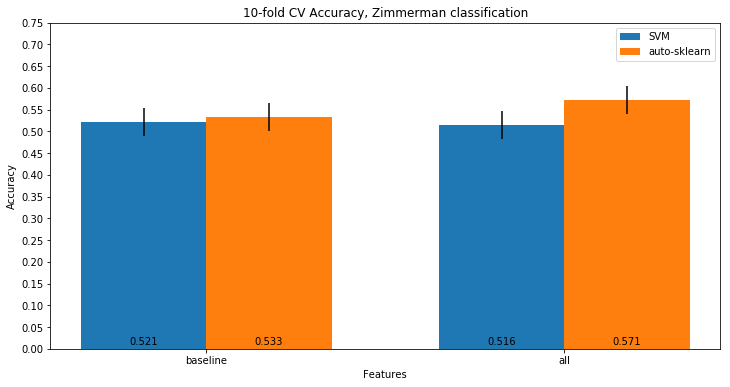

In [14]:
plot_results(svc_acc, automl_acc, "SVM", features, 
             "Accuracy", "10-fold CV Accuracy, Zimmerman classification",
            automl_stderrs=automl_std,
            baseline_stderrs=svc_std)


In [15]:
svc_base_mean_f1 = np.mean(svc_base_f1)
svc_base_std_f1 = np.std(svc_base_f1)
svc_all_mean_f1 = np.mean(svc_all_f1)
svc_all_std_f1 = np.std(svc_base_f1)

svc_f1 = [svc_base_mean_f1, svc_all_mean_f1]
svc_std = [svc_base_std_f1, svc_all_std_f1]

In [16]:
automl_base_mean_f1 = np.mean(automl_base_f1)
automl_base_std_f1 = np.std(automl_base_f1)
automl_all_mean_f1 = np.mean(automl_all_f1)
automl_all_std_f1 = np.std(automl_base_f1)

automl_f1 = [automl_base_mean_f1, automl_all_mean_f1]
automl_std = [automl_base_std_f1, automl_all_std_f1]

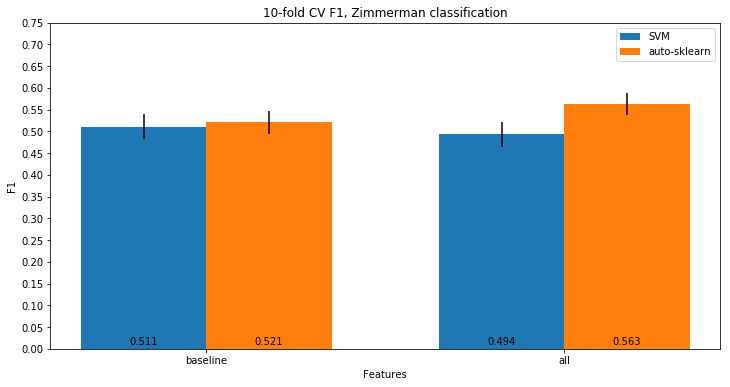

In [17]:
plot_results(svc_f1, automl_f1, "SVM", features, 
             "F1", "10-fold CV F1, Zimmerman classification",
            automl_stderrs=automl_std,
            baseline_stderrs=svc_std)


## Test set performance

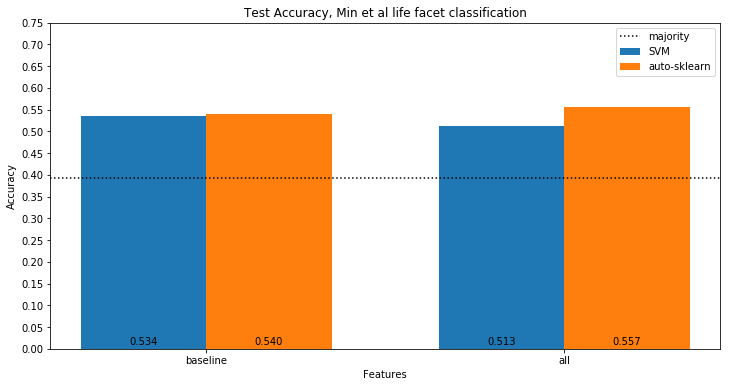

In [18]:
svc_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in svc_preds]
automl_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in automl_preds]
majority_acc = sk_metrics.accuracy_score(test_y, [2] * len(test_y))

plot_results(svc_acc, automl_acc, "SVM", features, "Accuracy", "Test Accuracy, Min et al life facet classification", majority_acc)

/home/tliu526/miniconda3/envs/auto-sklearn/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


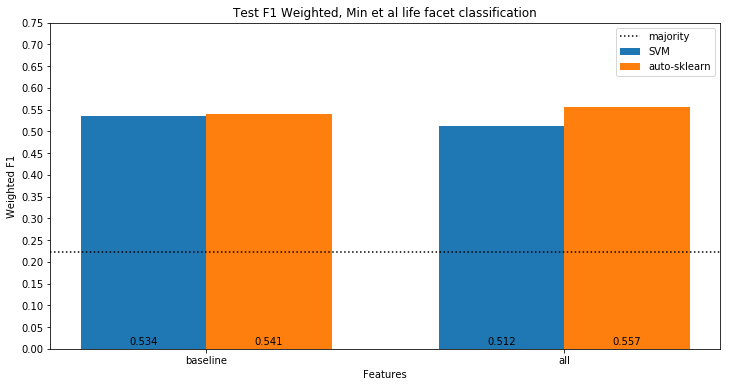

In [19]:
svc_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in svc_preds]
automl_f1 = [sk_metrics.f1_score(test_y, pred, average='weighted') for pred in automl_preds]
majority_f1 = sk_metrics.f1_score(test_y, [2] * len(test_y), average='weighted')

plot_results(svc_f1, automl_f1,  "SVM", features, "Weighted F1", "Test F1 Weighted, Min et al life facet classification", majority_f1)

### Min et al. Confusion Matrix

- note: not completely comparable, different slice of the data
![](zimmerman_figs/confusion_matrix.png)

## Our results

### SVM confusion matrix

In [20]:
print_confusion_matrix(test_y, svc_preds[-1], zimmerman_contact_types)

,p_work,p_social,p_family
work,127,80,26
social,75,219,73
family,83,144,161


### AutoML confusion matrix

In [21]:
all_ensemble = automl_models[-1].get_models_with_weights()
print_ensemble(all_ensemble)

print_confusion_matrix(test_y, automl_preds[-1], zimmerman_contact_types)

Weight: 0.38, classifier: adaboost
Weight: 0.14, classifier: gradient_boosting
Weight: 0.12, classifier: adaboost
Weight: 0.06, classifier: gradient_boosting
Weight: 0.06, classifier: random_forest
Weight: 0.04, classifier: gradient_boosting
Weight: 0.04, classifier: gradient_boosting
Weight: 0.04, classifier: lda
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: gradient_boosting
Weight: 0.02, classifier: random_forest


,p_work,p_social,p_family
work,141,62,30
social,71,216,80
family,63,132,193


# Wiese et al Tie Strength Replication

- same communication feature set
- support vector machines as classification algorithm
- Leave-one-participant-out cross validation for evaluation

## Wiese et al results

- our data is comparable to "some comm," as indicated by red arrows

![](zimmerman_figs/tie_str_results.png)

## Test set performance

In [22]:
# load models and data
features = ['baseline', 'all']

svc_models = []
svc_preds = []
svc_cv_preds = []
# baseline
for feat in features:
    with open("../model/final_results/tie_str/tie_str_{}_svm.automl".format(feat), 'rb') as model_file:
            svc_models.append(pickle.load(model_file))
    with open("../model/final_results/tie_str/tie_str_{}_svm.predict".format(feat), 'rb') as pred_file:
        svc_preds.append(pickle.load(pred_file))
#     with open("../model/final_results/tie_str/{}_svm.cv_predict".format(feat), 'rb') as cv_file:
#         svc_cv_preds.append(pickle.load(cv_file))


automl_models = []
automl_preds = []
automl_cv_preds = []

# autoML
for feat in features:
    with open("../model/final_results/tie_str/tie_str_{}_automl.automl".format(feat), 'rb') as model_file:
        automl_models.append(pickle.load(model_file))
    with open("../model/final_results/tie_str/tie_str_{}_automl.predict".format(feat), 'rb') as pred_file:
        automl_preds.append(pickle.load(pred_file))
#     with open("../model/final_results/tie_str/{}_automl.cv_predict".format(feat), 'rb') as cv_file:
#         automl_cv_preds.append(pickle.load(cv_file))


Could not delete output dir: /tmp/autosklearn_output_5605_6449
Could not delete tmp dir: /tmp/autosklearn_tmp_5605_6449
Could not delete output dir: /tmp/autosklearn_output_5535_5541
Could not delete tmp dir: /tmp/autosklearn_tmp_5535_5541
Could not delete output dir: /tmp/autosklearn_output_6627_6780
Could not delete tmp dir: /tmp/autosklearn_tmp_6627_6780
Could not delete output dir: /tmp/autosklearn_output_8510_2230
Could not delete tmp dir: /tmp/autosklearn_tmp_8510_2230


In [23]:
# load data
train = pickle.load(open('../data/final_features/all_tie_str_baseline_train_features.df', 'rb'))
test =  pickle.load(open('../data/final_features/all_tie_str_baseline_test_features.df', 'rb'))

train_data = train.replace(replace_dict)
test_data = test.replace(replace_dict)

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness',
    'tie_str_score',
    'tie_str_rank',
    'tie_str_class'
]

train_y = train_data['tie_str_class']
train_X = train_data.drop(['contact_type', 'pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
test_y = test_data['tie_str_class']
test_X = test_data.drop(['contact_type', 'pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

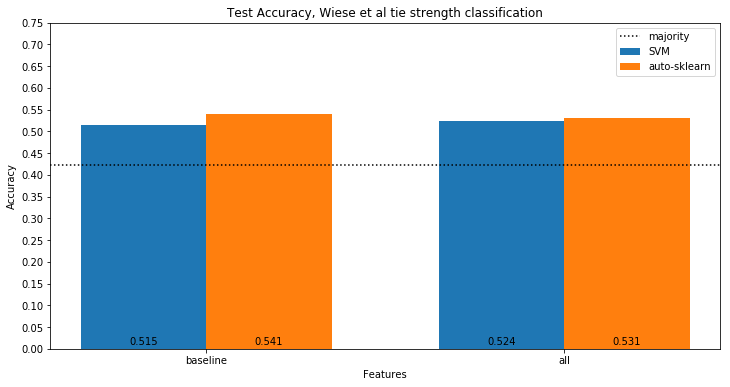

In [24]:
svc_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in svc_preds]
automl_acc = [sk_metrics.accuracy_score(test_y, pred) for pred in automl_preds]
majority_acc = sk_metrics.accuracy_score(test_y, [2] * len(test_y))

plot_results(svc_acc, automl_acc, "SVM", features, "Accuracy", "Test Accuracy, Wiese et al tie strength classification", majority_acc)

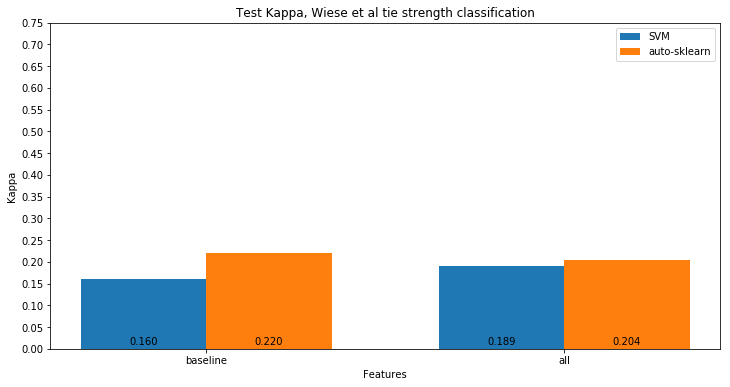

In [25]:
svc_acc = [sk_metrics.cohen_kappa_score(test_y, pred) for pred in svc_preds]
automl_acc = [sk_metrics.cohen_kappa_score(test_y, pred) for pred in automl_preds]

plot_results(svc_acc, automl_acc, "SVM", features, "Kappa", "Test Kappa, Wiese et al tie strength classification")

## SVM Confusion Matrix

In [36]:
print_confusion_matrix(test_y, svc_preds[0], ['strong', 'medium', 'weak'])

,p_strong,p_medium,p_weak
strong,21,171,106
medium,15,442,442
weak,0,272,605


## AutoML Confusion Matrix

In [37]:
print_confusion_matrix(test_y, automl_preds[0], ['strong', 'medium', 'weak'])

,p_strong,p_medium,p_weak
strong,63,161,74
medium,48,448,403
weak,9,258,610


In [38]:
strong_recall_svc = [sk_metrics.recall_score(test_y, pred, labels=[2], average='macro') for pred in svc_preds]